In [1]:
!pip install csvkit

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!csvsql --db sqlite:///InternetSpeed.db --insert ./Data/LA_wifi_speed_UK.csv

In [3]:
import sqlite3 as sql, re, pandas as pd
from matplotlib import pyplot as plt

In [4]:
con = sql.connect('Internetspeed.db')
cur = con.cursor()

In [6]:
query_date = 'SELECT Datetime FROM LA_wifi_speed_UK ORDER BY RANDOM() LIMIT 10'

for row in cur.execute(query_date):
    print(row)

('2016-11-29 13:30:00.000000',)
('2016-12-12 22:30:00.000000',)
('2016-12-13 14:30:00.000000',)
('2016-11-23 17:00:00.000000',)
('2016-12-07 06:30:00.000000',)
('2016-12-13 17:30:00.000000',)
('2016-11-23 05:00:00.000000',)
('2016-11-28 07:30:00.000000',)
('2016-12-12 04:00:00.000000',)
('2016-11-27 02:00:00.000000',)


In [7]:
query_desc = 'SELECT * FROM LA_wifi_speed_UK LIMIT 1'
col = [n[0] for n in cur.execute(query_desc).description]
col = col[1:]
col = [re.sub(r'_\w', '', c) for c in col]
col = list(set(col))
col.remove('DateTime')

Text(0.5, 1.0, 'E07000148')

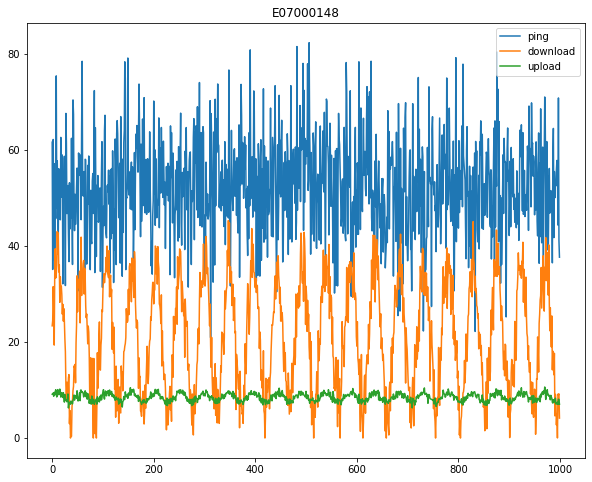

In [8]:
plt.figure(figsize = (10, 8))
suffix = {'_p':'ping', '_d':'download', '_u':'upload'}

for (k, v) in suffix.items():
    cur.execute(f'SELECT {col[0]}{k} FROM LA_wifi_speed_UK ORDER BY DateTime')
    plt.plot(cur.fetchall(), label = v, )

plt.legend()
plt.title(col[0])

In [9]:
df = pd.DataFrame(columns = ['Area', 'Average_p', 'Average_d', 'Average_u'])

In [10]:
for c in col:
    l = [c]
    for (k, v) in suffix.items():
        cur.execute(f'SELECT AVG({c + k}) FROM LA_wifi_speed_UK')
        l.append(cur.fetchone()[0])

    df = df.append(pd.Series(l, df.columns), ignore_index = True)

df.head()

,Area,Average_p,Average_d,Average_u
0,E07000148,52.250511,21.373443,8.483157
1,E06000045,53.894639,22.458597,8.856190
2,E08000022,53.106180,21.811590,8.743520
3,E07000169,51.153378,20.833897,8.292849
4,E07000112,51.965947,21.063988,8.394836


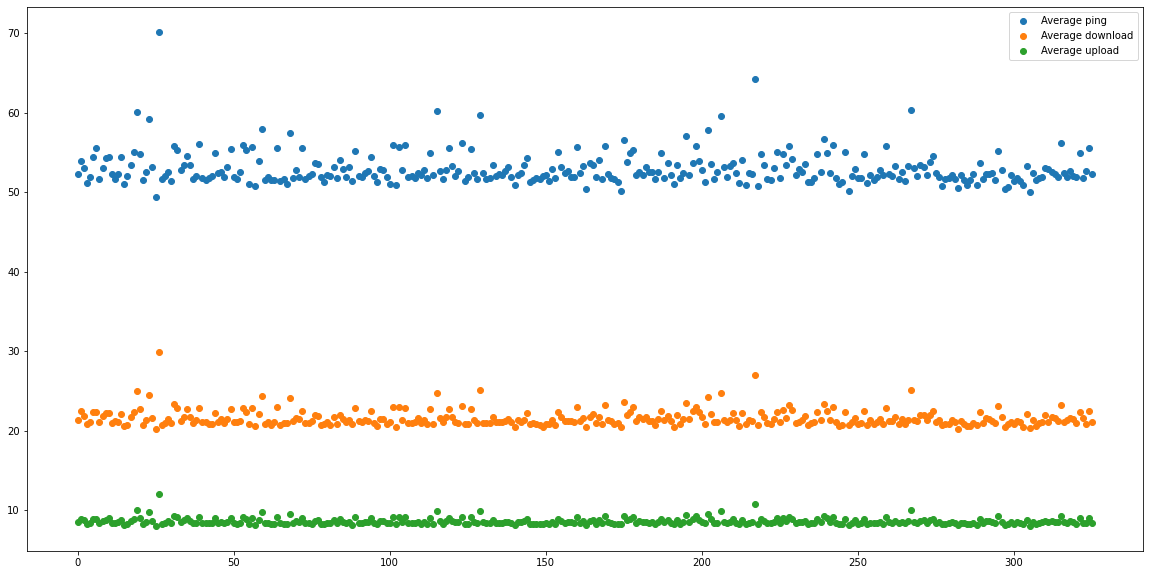

In [11]:
plt.figure(figsize = (20, 10))
plt.plot(df.index, df[['Average_p', 'Average_d', 'Average_u']], 'o')
plt.legend(['Average ping', 'Average download', 'Average upload'])

In [12]:
try:
    cur.execute('DROP TABLE average_speed')
except:
    pass

df.to_sql('average_speed', con)

In [13]:
for r in cur.execute('SELECT * FROM average_speed').fetchmany(4):
    print(r)

(0, 'E07000148', 52.250511098548756, 21.373443161390096, 8.483157470561897)
(1, 'E06000045', 53.894639309570856, 22.45859662280872, 8.85619030558592)
(2, 'E08000022', 53.10618008248502, 21.811589604058497, 8.743519624673066)
(3, 'E07000169', 51.15337826773647, 20.833897456223976, 8.292848576411473)


In [15]:
con.close()

In [16]:
!csvsql --db sqlite:///InternetSpeed.db --insert ./Data/LA_population.csv

In [17]:
con = sql.connect('Internetspeed.db')
cur = con.cursor()

In [18]:
for r in cur.execute('SELECT * FROM LA_population').fetchmany(4):
    print(r)

('Aberdeen City', 'S12000033', 222793.0)
('Aberdeenshire', 'S12000034', 252973.0)
('Adur', 'E07000223', 61182.0)
('Allerdale', 'E07000026', 96422.0)


In [19]:
cur.execute('SELECT * FROM average_speed JOIN LA_population ON average_speed.Area = LA_population.LA_code')
for r in cur.fetchmany(4):
    print(r)

(0, 'E07000148', 52.250511098548756, 21.373443161390096, 8.483157470561897, 'Norwich', 'E07000148', 132512.0)
(1, 'E06000045', 53.894639309570856, 22.45859662280872, 8.85619030558592, 'Southampton', 'E06000045', 236882.0)
(2, 'E08000022', 53.10618008248502, 21.811589604058497, 8.743519624673066, 'North Tyneside', 'E08000022', 200801.0)
(3, 'E07000169', 51.15337826773647, 20.833897456223976, 8.292848576411473, 'Selby', 'E07000169', 83449.0)


"Можете ли вы сейчас ответить на вопрос о зависимости средней скорости Интернет-подключения от населенности района?"

In [20]:
query = 'SELECT Area, Average_p, Average_d, Average_u, Total_Population FROM average_speed JOIN LA_population ON average_speed.Area = LA_population.LA_code'
cur.execute(query)

print(cur.fetchone())

df = pd.DataFrame(columns = ['Area', 'Average_p', 'Average_d', 'Average_u', 'Population'])
for c in cur.fetchall():
    df = df.append(pd.Series(c, df.columns), ignore_index = True)

df.head()

('E07000148', 52.250511098548756, 21.373443161390096, 8.483157470561897, 132512.0)


,Area,Average_p,Average_d,Average_u,Population
0,E06000045,53.894639,22.458597,8.856190,236882.0
1,E08000022,53.106180,21.811590,8.743520,200801.0
2,E07000169,51.153378,20.833897,8.292849,83449.0
3,E07000112,51.965947,21.063988,8.394836,107969.0
4,E08000031,54.469368,22.406534,8.899992,249470.0


In [23]:
sorted_asc = df.sort_values(['Population'])
sorted_asc.head()

,Area,Average_p,Average_d,Average_u,Population
304,E06000053,50.084966,20.358606,8.004334,2203.0
24,E09000001,49.384769,20.165312,8.047228,7375.0
281,E07000191,50.492327,20.280303,8.154217,34675.0
14,E06000017,50.992436,20.572656,8.153301,37369.0
162,E07000051,50.481485,20.484920,8.152685,44973.0


In [24]:
sorted_dsc = df.sort_values(['Population'], ascending = False)
sorted_dsc.head()

,Area,Average_p,Average_d,Average_u,Population
25,E08000025,70.192955,29.853411,11.999448,1073045.0
216,E08000035,64.302549,26.995125,10.790424,751485.0
266,E08000019,60.352773,25.068847,10.052675,552698.0
128,E06000052,59.742131,25.161968,9.963647,532273.0
18,E08000032,60.068885,24.982134,9.982742,522452.0


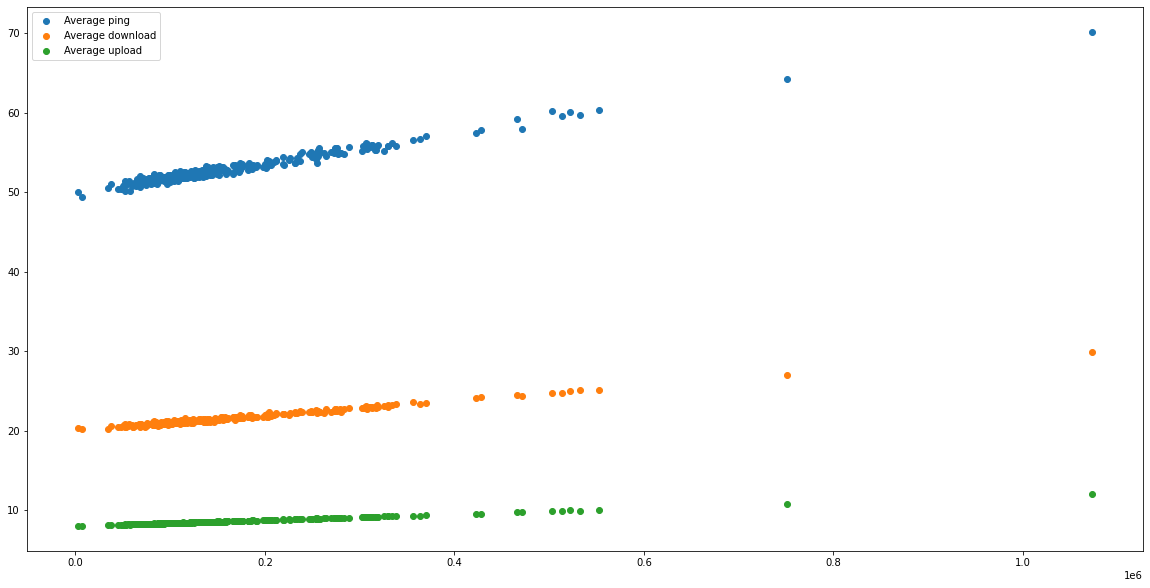

In [25]:
plt.figure(figsize = (20, 10))
plt.plot(df['Population'], df[['Average_p', 'Average_d', 'Average_u']], 'o')
plt.legend(['Average ping', 'Average download', 'Average upload'])